# Evaluate the Closed-Loop Control on Telescope Mount Assembly with the Azimuth Movement

This notebook is to evaluate the closed-loop control (CLC) on telescope mount assembly (TMA) with the azimuth movement.
When the vendor developed the M2, the M2 was attached to a cart that could not simulate the azimuth movement of TMA.
In addition, the cart can only reach the 5% velocity of TMA at the elevation movement, which equals to 0.25 deg/sec.
Therefore, we would need to evaluate the CLC under higher velocities at the azimuth and elevation directions.
But before this, let us check the CLC under the slow azimuth movement first.

Currently, the CLC of M2 uses two simple P-controllers at the feedforward and feedback loops (there are total 32 parameters can be tuned in the system).
Since the M2 uses the step actuators, it should be insensitive to the natural frequencies of TMA or azimuth movement.
We would like to confirm this in this notebook.

## Summary

1. The net moment does not show the significant difference between the open-loop and closed-loop controls under the slow azimuth movement.
2. The peaks of net moment ($m_{y}$ and $m_{z}$) reflect the acceleration/deceleration of azimuth movement.
In contrast, $m_{x}$ has the low sensitivity of this.

## Import Modules

In [1]:
%matplotlib inline
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing
from astropy.time import Time
from pandas.core.frame import DataFrame

from lsst.ts.aos.utils import DiagnosticsM2, DiagnosticsMTMount, EfdName

## Declaration of User-Defined Functions

In [2]:
def plot_elevation_positions(
    data_elevations: list[DataFrame],
    time_operations: list[numpy.typing.NDArray[np.float64]],
    legend: list[str],
) -> None:
    """Plot the elevation positions.

    Parameters
    ----------
    data_elevations : `list`
        Elevation datas.
    time_operations : `list`
        Operation times in second.
    legend : `list`
        Legend.
    """

    plt.figure()
    for time_operation, data_elevation in zip(time_operations, data_elevations):
        plt.plot(time_operation, data_elevation.actualPosition)

    plt.xlabel("Time (sec)")
    plt.ylabel("Elevation Position (deg)")

    plt.title("Elevation Angle")
    plt.legend(legend)

    plt.show()

In [3]:
async def show_all_data(
    diagnostics_mtmount: DiagnosticsMTMount,
    diagnostics_m2: DiagnosticsM2,
    time_start: Time,
    time_end: Time,
) -> None:
    """
    Show all the data.

    Parameters
    ----------
    diagnostics_mtmount : `lsst.ts.aos.utils.DiagnosticsMTMount`
        MTMount diagnostics instance.
    diagnostics_m2 : `lsst.ts.aos.utils.DiagnosticsM2`
        M2 diagnostics instance.
    time_start : `astropy.time.core.Time`
        Start time.
    time_end : `astropy.time.core.Time`
        End time.
    """

    data_azimuth, time_operation = await diagnostics_mtmount.get_data_azimuth(time_start, time_end)
    data_net_moment, time_operation_net_moment = await diagnostics_m2.get_data_net_moment(time_start, time_end)

    diagnostics_mtmount.plot_velocity(data_azimuth, time_operation, title="Azimuth")
    diagnostics_m2.plot_net_moment(data_net_moment, time_operation_net_moment)

## Instantiate the Diagnostics Classes

In [4]:
diagnostics_m2 = DiagnosticsM2(efd_name=EfdName.Usdf)
diagnostics_mtmount = DiagnosticsMTMount(efd_name=EfdName.Usdf)

## Compare the Open-Loop and Closed-Loop Controls at the Azimuth Movement

The M2 performance of closed-loop control is evaluated under the azimuth velecity of 1% ([BLOCK-99](https://jira.lsstcorp.org/browse/BLOCK-99)), 3% ([BLOCK-100](https://jira.lsstcorp.org/browse/BLOCK-100)), and 5% ([BLOCK-101](https://jira.lsstcorp.org/browse/BLOCK-101)).
The related velocities are 0.1 deg/sec, 0.3 deg/sec, and 0.5 deg/sec.

## Times of the Tests

In [5]:
# 1% velocity
time_start_1 = Time("2023-11-16T08:20:30", scale="utc", format="isot")
time_end_1 = Time("2023-11-16T08:33:00", scale="utc", format="isot")

# 3% velocity
time_start_3 = Time("2023-11-16T08:42:52", scale="utc", format="isot")
time_end_3 = Time("2023-11-16T08:48:10", scale="utc", format="isot")

# 5% velocity
time_start_5 = Time("2023-11-16T08:54:57", scale="utc", format="isot")
time_end_5 = Time("2023-11-16T09:01:00", scale="utc", format="isot")

# Events of the force balance system status
time_start_event = Time("2023-11-16T08:19:00", scale="utc", format="isot")
time_end_event = Time("2023-11-16T09:10:00", scale="utc", format="isot")

## Check the Elevation Angle

The elevation angle is 45 degree in the tests.

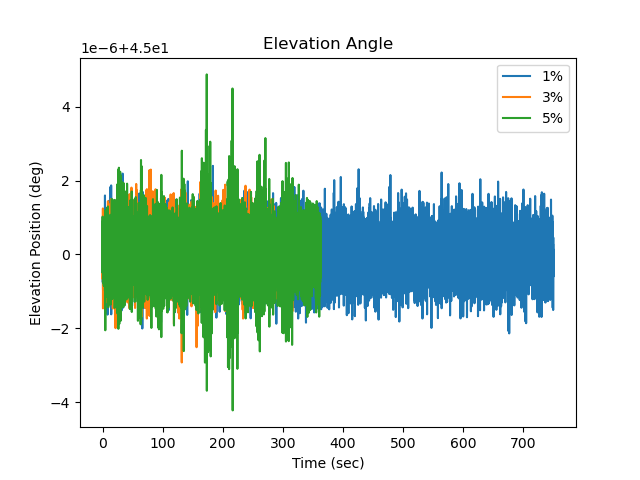

In [6]:
data_elevation_1, time_elevation_operation_1 = await diagnostics_mtmount.get_data_elevation(
    time_start_1, time_end_1)
data_elevation_3, time_elevation_operation_3 = await diagnostics_mtmount.get_data_elevation(
    time_start_3, time_end_3)
data_elevation_5, time_elevation_operation_5 = await diagnostics_mtmount.get_data_elevation(
    time_start_5, time_end_5)

plot_elevation_positions(
    [data_elevation_1, data_elevation_3, data_elevation_5],
    [time_elevation_operation_1, time_elevation_operation_3, time_elevation_operation_5],
    ["1%", "3%", "5%"],
)

## Event of the Force Balance System Status

Time range here contains all the tests of 1%, 3%, and 5%.
Therefore, we should see three times of turning on/off force balance system.

In [7]:
event_fbs, time_send = await diagnostics_m2.get_event_force_balance_system_status(
    time_start_event, time_end_event, realign_time=False)

print(f"Force balance system status:\n{event_fbs}")

Force balance system status:
                                  status  private_sndStamp
2023-11-16 08:19:40.360435+00:00   False      1.700123e+09
2023-11-16 08:32:47.635357+00:00    True      1.700124e+09
2023-11-16 08:40:31.898287+00:00   False      1.700124e+09
2023-11-16 08:47:43.855249+00:00    True      1.700125e+09
2023-11-16 08:54:43.641168+00:00   False      1.700125e+09
2023-11-16 09:00:42.974545+00:00    True      1.700125e+09


### 1% Azimuth Velocity

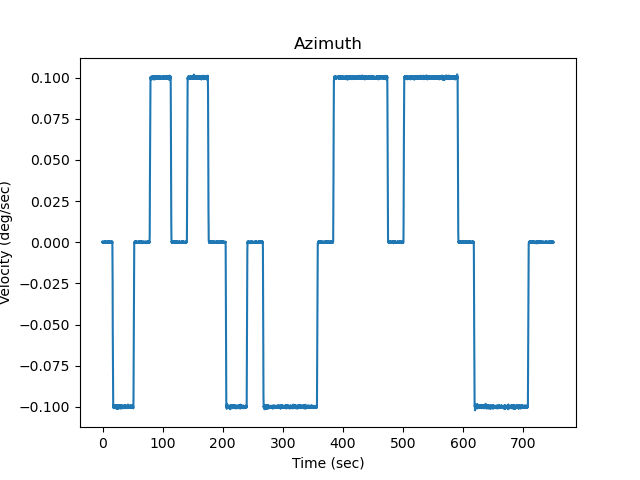

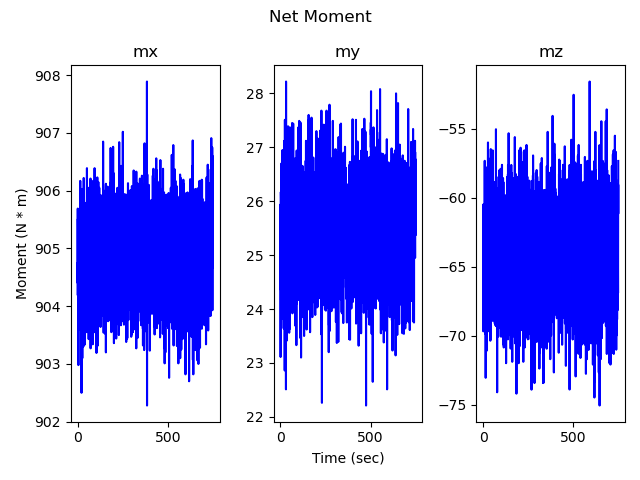

In [8]:
await show_all_data(diagnostics_mtmount, diagnostics_m2, time_start_1, time_end_1)

### 3% Azimuth Velocity

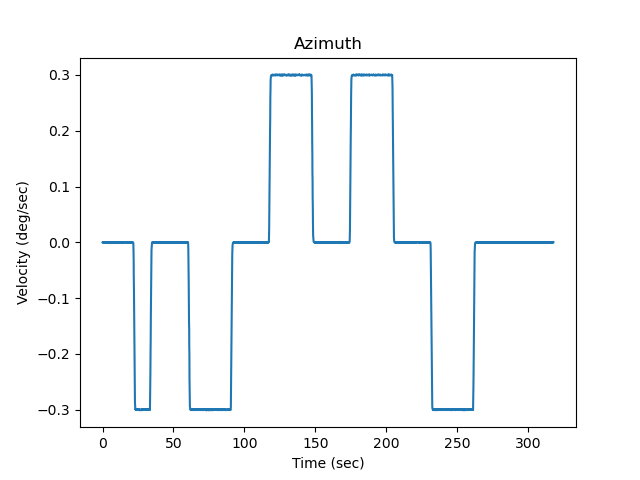

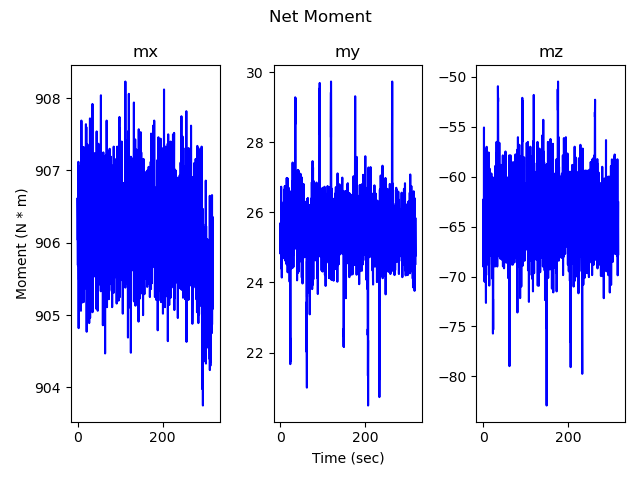

In [9]:
await show_all_data(diagnostics_mtmount, diagnostics_m2, time_start_3, time_end_3)

### 5% Azimuth Velocity

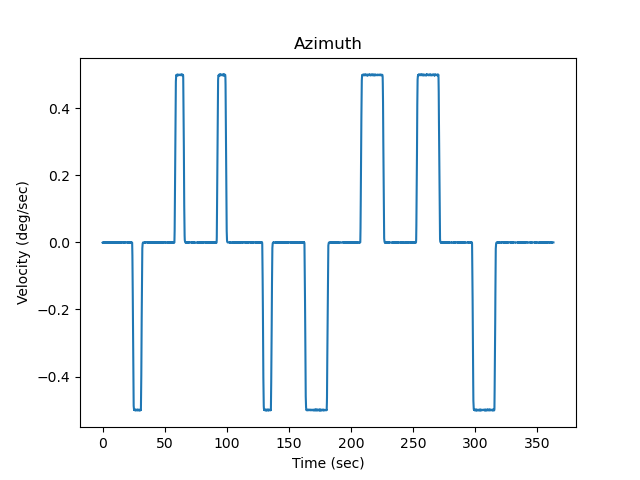

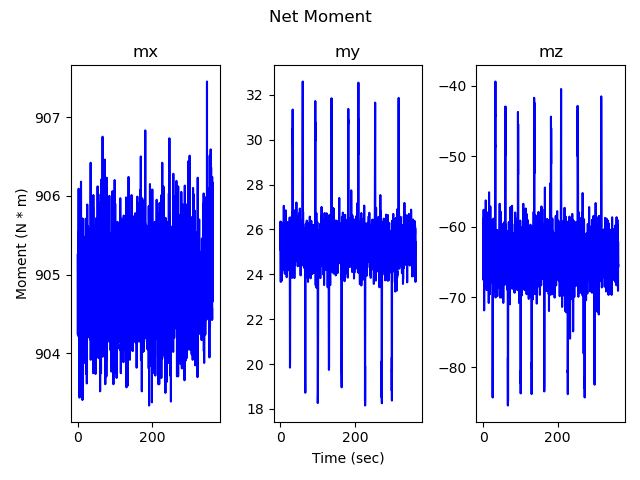

In [10]:
await show_all_data(diagnostics_mtmount, diagnostics_m2, time_start_5, time_end_5)

In [ ]:
plt.close()